In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy import signal
from tqdm.notebook import tqdm
from scipy.constants import Planck, c, elementary_charge
from readTrc import Trc
from matplotlib.gridspec import GridSpec

# Specify path to your files

In [3]:
#choose data
data_dir                = './Lito2 E20/1540nm 32dB 43mK 8p104uA/'
channels                = ['C1']

#The path to your TXT file.
data_nofilter_1540      = './Lito2 E20/1540nm 32dB 43mK 8p104uA/F1--XX-Lito2_E20_43mK_8p104uA_nofilter_1540nm_32dB--00000.txt'
data_nofilter_850       = './Lito2 E20/F1--Lito2_E20_43mK_8p104uA_nofilter_850nm--00000.txt'
data_nofilter_406       = './Lito2 E20/F1--Lito2_E20_43mK_8p104uA_nofilter_406nm--00000.txt'
data_nofilter_1540_24db = './Lito2 E20/F1--XX-Lito2_E20_43mK_8p104uA_nofilter_1540nm_24dB--00000.txt'

# Extract traces

In [4]:
# Load the data per channel
filenames           = {channel: [file for file in os.listdir(data_dir) if channel in file] for channel in channels}
# Dont forget to sort them so that coincidences will match up correctly
for channel in channels:
    filenames[channel]=np.sort(filenames[channel])
    
# Load the data
trc_loader          = Trc()   # Create a loader object
traces              = {channel: [trc_loader.open(os.path.join(data_dir,filename)) for filename in filenames[channel]] for channel in channels}

# Create arrays of events and their time
events              = []
events_time         = [] # not used for analysis, but could be helpful for plotting events
ch = 'C1'
# Since some traces have different lenghts we need to trim them
for j in range(0, len(traces[ch])):
    if len(traces[ch][j][1]) == 2502000:
        for i in range(0, (len(traces[ch][j][1]) // 2502)):
            events.append(traces[ch][j][1][ 1 + i*2502: (i+1)*2502 - 1])
            events_time.append(traces[ch][j][0][1+ i*2502: (i+1)*2502 - 1])
    else:
        for i in range(0, (len(traces[ch][j][1]) // 2501)):
            events.append(traces[ch][j][1][ 1 + i*2501: (i+1)*2501])
            events_time.append(traces[ch][j][0][ 1 + i*2501: (i+1)*2501])
print(len(events)) # check how many events we have

51000


# Filter the data

In [5]:
# Sosfilter the signal data
sos             =   signal.butter(2,1/15, output='sos')
butterybiscuits = signal.sosfilt(sos, events)
data = np.array(butterybiscuits) #np.array(events)

# Find the amplitude of the signal minus the baseline
baseline = np.mean(data[:, :250], axis=1)
min = np.min(data[:, 250:250*3], axis=1)
amp = baseline-min

# Create a histogram object
hist, bin_edges = np.histogram(amp, bins=500, range=(-0.01, 0.09))

# Find bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_centers = np.array(bin_centers, dtype=object)

# Store the corresponding values for each bin
bin_values = []
for i in range(len(bin_centers)):
    # Get the values in each bin
    values_in_bin = len(amp[(amp >= bin_edges[i]) & (amp < bin_edges[i + 1])])
    bin_values.append(values_in_bin)
# bin_values is now a list of arrays, where each array contains the values in a bin


# Histogram filtered

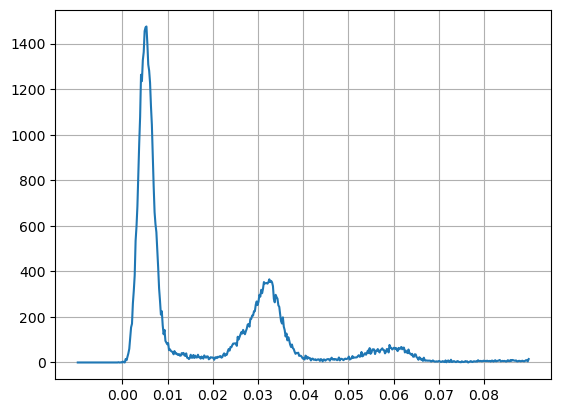

In [6]:
# Optionally, you can convert bin_values to a NumPy array if needed
bin_values = np.array(bin_values, dtype=object)
# Plot a graph of a histogram 
x=bin_centers
y=bin_values
plt.figure()
plt.plot(x,y)
plt.grid()
plt.xticks(np.arange(0, 0.09, step=0.01))
plt.show()

# Multigaussian fit for filtered data

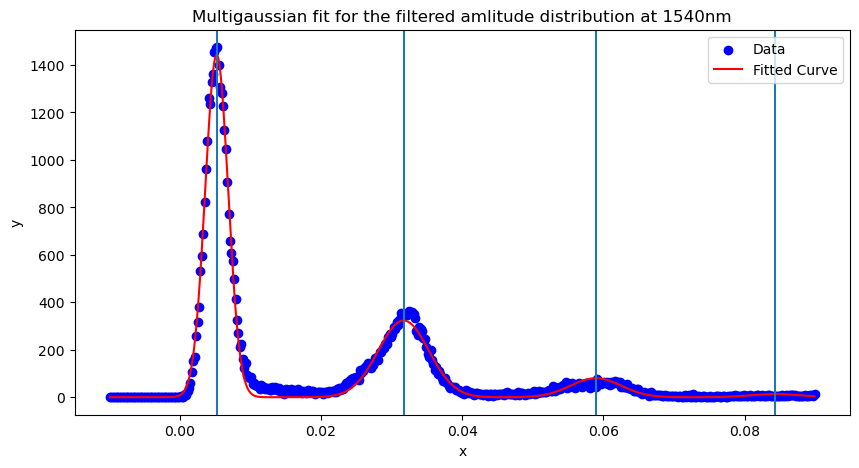

A: 9.637411815040254
mu: 0.496309308104448
x0: 0.005208660942922998
x1: 0.0316854881575394
x2: 0.05892972490722246
x3: 0.08434898976395779
s0: 0.001622260583022791
s: 0.0035925100599473307


In [7]:
# Define the function as the sum of multiple Gaussian distributions
def fgauss(x, A, mu, x0, x1, x2, x3, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
        np.exp(-(x - x0) ** 2 / (2 * s0 ** 2)) / s0 +
        mu * np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / 2 * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / 6 * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s
    )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses = (19, 0.6, 0.005, 0.025, 0.051, 0.075, 0.005, 0.003)


# Fit the curve to your data
params, covariance = curve_fit(fgauss, x, y, p0=initial_guesses, maxfev=10000)

# The optimized parameters are in 'params'
A_fit, mu_fit, x0_fit, x1_fit, x2_fit, x3_fit, s0_fit, s_fit = params

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x), max(x), 1000)
y_curve = fgauss(x_curve, *params)

# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='Data', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit)
plt.axvline(x1_fit)
plt.axvline(x2_fit)
plt.axvline(x3_fit)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Multigaussian fit for the filtered amlitude distribution at 1540nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit}")
print(f"mu: {mu_fit}")
print(f"x0: {x0_fit}")
print(f"x1: {x1_fit}")
print(f"x2: {x2_fit}")
print(f"x3: {x3_fit}")
print(f"s0: {s0_fit}")
print(f"s: {s_fit}")

# Analyse the data from the oscilloscope (1540nm high attenuation)

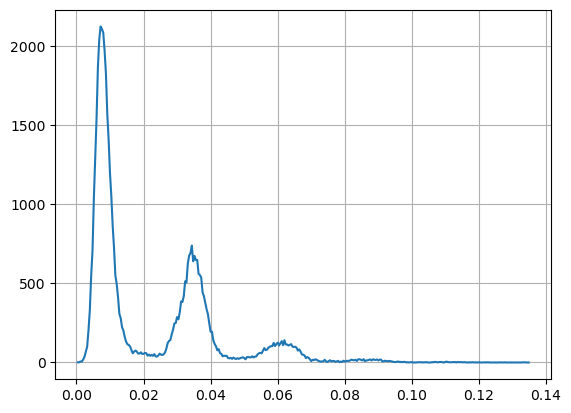

In [8]:
# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df = pd.read_csv(data_nofilter_1540, delimiter=',', skiprows=5)  # Change '\t' to the actual delimiter used in your file
data = np.array(df)

# Take only positive amplitudes
data = np.array(df[df.iloc[:, 0]>0])

x_1540=data[:, 0]
y_1540=data[:, 1]

plt.plot(x_1540,y_1540)
plt.grid()
plt.show()


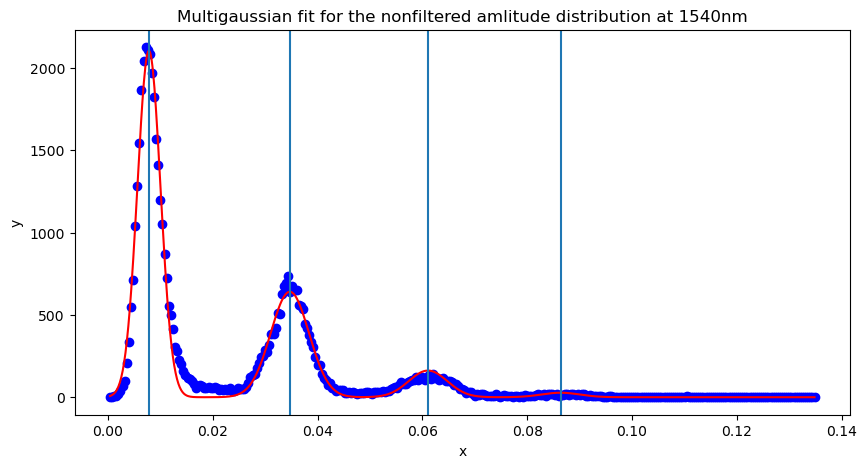

A: 19.302074096027578
mu: 0.5057108521949585
x0: 0.007825557996995263
x1: 0.034705970480805357
x2: 0.06106114453391413
x3: 0.08635126156615612
s0: 0.002207280305836893
s: 0.0036681060165889515


In [9]:
# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_old = (25.0, 0.5, 0.005, 0.032, 0.06, 0.085, 0.005, 0.007)


# Fit the curve to your data
params_1540, covariance = curve_fit(fgauss, x_1540, y_1540, p0=initial_guesses_old, maxfev=10000)

# The optimized parameters are in 'params'
A_fit_old, mu_fit_old, x0_fit_old, x1_fit_old, x2_fit_old, x3_fit_old, s0_fit_old, s_fit_old = params_1540

# Generate data points for the fitted curve
x_curve = np.linspace(np.min(x_1540), max(x_1540), 1000)
y_curve = fgauss(x_curve, *params_1540)

# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_1540, y_1540, label='Nonfiltered 1540', color='b')
plt.plot(x_curve, y_curve, label='Fitted Curve', color='r')
plt.axvline(x0_fit_old)
plt.axvline(x1_fit_old)
plt.axvline(x2_fit_old)
plt.axvline(x3_fit_old)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Multigaussian fit for the nonfiltered amlitude distribution at 1540nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_old}")
print(f"mu: {mu_fit_old}")
print(f"x0: {x0_fit_old}")
print(f"x1: {x1_fit_old}")
print(f"x2: {x2_fit_old}")
print(f"x3: {x3_fit_old}")
print(f"s0: {s0_fit_old}")
print(f"s: {s_fit_old}")


# Analyse the data from the oscilloscope (1540nm low attenuation)

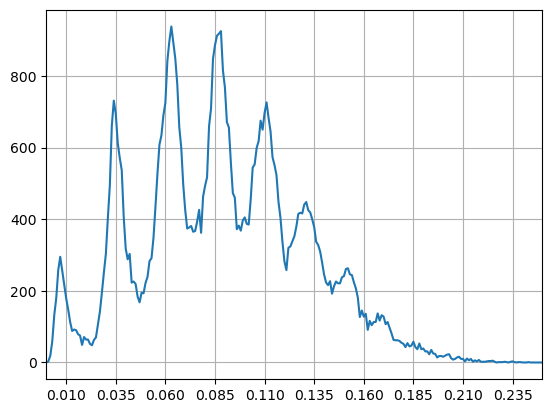

In [10]:
# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df_1540_24db = pd.read_csv(data_nofilter_1540_24db, delimiter=',', skiprows=5)  # Change '\t' to the actual delimiter used in your file
data_1540_24db = np.array(df_1540_24db)

# Take only positive amplitudes
data = np.array(df_1540_24db[df_1540_24db.iloc[:, 0]>0])

x_1540_24db=data[:, 0]
y_1540_24db=data[:, 1]

plt.plot(x_1540_24db,y_1540_24db)
plt.xlim(0, 0.25)
plt.xticks(np.arange(0.01, 0.25, 0.025))
plt.grid()
plt.show()

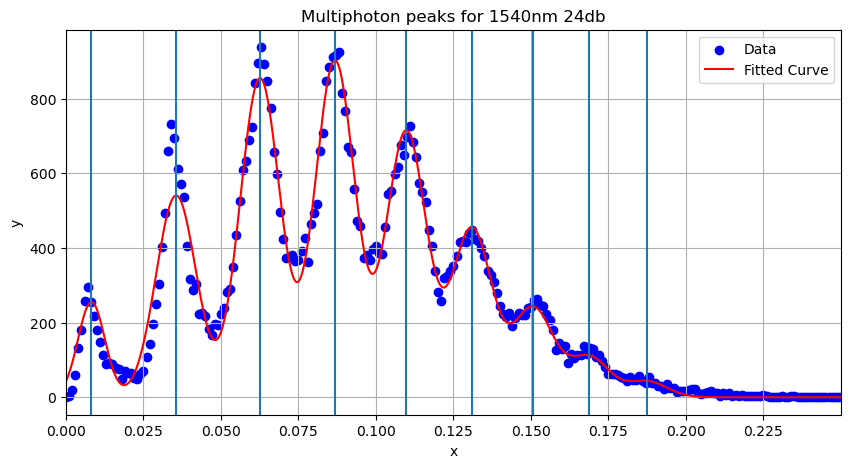

A: 65.59161874475582
mu: 3.1617875861644604
x0: 0.008233020850410576
x1: 0.03555915089870999
x2: 0.06260565234961678
x3: 0.08678080092776902
x4: 0.10978844510382754
x5: 0.130958898511762
x6: 0.15068035585563871
x7: 0.1687338409574665
x8: 0.18738735470439477
s0: 0.004341308554249237
s: 0.006482280974894136


In [11]:
# Define your new function for more Gaussian distributed peaks
def fgauss_1540_24db(x, A, mu, x0, x1, x2, x3, x4, x5, x6, x7, x8, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
                                         np.exp(-(x - x0) ** 2 / (2 * s0 ** 2))/ s0+
        mu *                             np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / np.math.factorial(2) * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / np.math.factorial(3) * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s +
        mu ** 4 / np.math.factorial(4) * np.exp(-(x - x4) ** 2 / (2 * s ** 2)) / s +
        mu ** 5 / np.math.factorial(5) * np.exp(-(x - x5) ** 2 / (2 * s ** 2)) / s +
        mu ** 6 / np.math.factorial(6) * np.exp(-(x - x6) ** 2 / (2 * s ** 2)) / s +
        mu ** 7 / np.math.factorial(7) * np.exp(-(x - x7) ** 2 / (2 * s ** 2)) / s +
        mu ** 8 / np.math.factorial(8) * np.exp(-(x - x8) ** 2 / (2 * s ** 2)) / s)
        # mu ** 9 / np.math.factorial(9) * np.exp(-(x - x9) ** 2 / (2 * s ** 2)) / s
        # )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_850 = (150, 3.2, 0.008, 0.0345, 0.062, 0.085, 0.110, 0.13, 0.145, 0.17, 0.185, 0.0048, 0.007)

# Fit the curve to your data
params_1540_24db, covariance_1540_24db = curve_fit(fgauss_1540_24db, x_1540_24db, y_1540_24db, p0=initial_guesses_850, maxfev=20000)

# The optimized parameters are in 'params'
A_fit_1540_24db, mu_fit_1540_24db, x0_fit_1540_24db, x1_fit_1540_24db, x2_fit_1540_24db, x3_fit_1540_24db, x4_fit_1540_24db, x5_fit_1540_24db, x6_fit_1540_24db, x7_fit_1540_24db, x8_fit_1540_24db, s0_fit_1540_24db, s_fit_1540_24db = params_1540_24db

# Generate data points for the fitted curve
x_curve_1540_24db = np.linspace(np.min(x_1540_24db), max(x_1540_24db), 10000)
y_curve_1540_24db = fgauss_1540_24db(x_curve_1540_24db, *params_1540_24db)
# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_1540_24db, y_1540_24db, label='Data', color='b')
plt.plot(x_curve_1540_24db, y_curve_1540_24db, label='Fitted Curve', color='r')
plt.axvline(x0_fit_1540_24db)
plt.axvline(x1_fit_1540_24db)
plt.axvline(x2_fit_1540_24db)
plt.axvline(x3_fit_1540_24db)
plt.axvline(x4_fit_1540_24db)
plt.axvline(x5_fit_1540_24db)
plt.axvline(x6_fit_1540_24db)
plt.axvline(x7_fit_1540_24db)
plt.axvline(x8_fit_1540_24db)
# plt.axvline(x9_fit_1540_24db)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Multiphoton peaks for 1540nm 24db')

# Show the plot
plt.xlim(0, 0.25)
plt.xticks(np.arange(0, 0.25, 0.025))
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_1540_24db}")
print(f"mu: {mu_fit_1540_24db}")
print(f"x0: {x0_fit_1540_24db}")
print(f"x1: {x1_fit_1540_24db}")
print(f"x2: {x2_fit_1540_24db}")
print(f"x3: {x3_fit_1540_24db}")
print(f"x4: {x4_fit_1540_24db}")
print(f"x5: {x5_fit_1540_24db}")
print(f"x6: {x6_fit_1540_24db}")
print(f"x7: {x7_fit_1540_24db}")
print(f"x8: {x8_fit_1540_24db}")
# print(f"x9: {x9_fit_1540_24db}")
print(f"s0: {s0_fit_1540_24db}")
print(f"s: {s_fit_1540_24db}")

# Analyse the data from the oscilloscope (850nm)

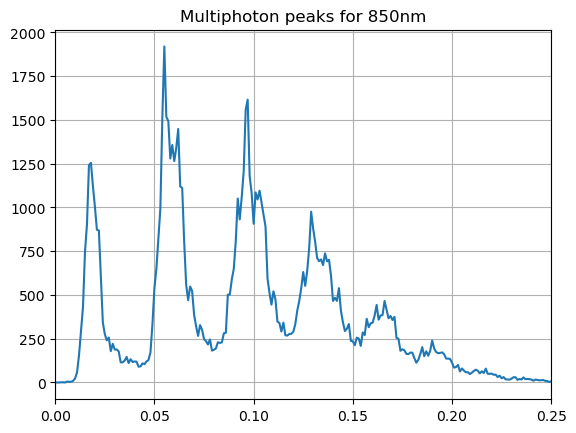

In [12]:

# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df_850 = pd.read_csv(data_nofilter_850, delimiter=',', skiprows=5)
data = np.array(df_850)
# Take only positive amplitudes
data = np.array(df_850[df_850.iloc[:, 0]>0])

x_850=data[:, 0]
y_850=data[:, 1]

plt.plot(x_850,y_850)
plt.xlim(0, 0.25)
plt.grid(True)
plt.title('Multiphoton peaks for 850nm')
plt.show()

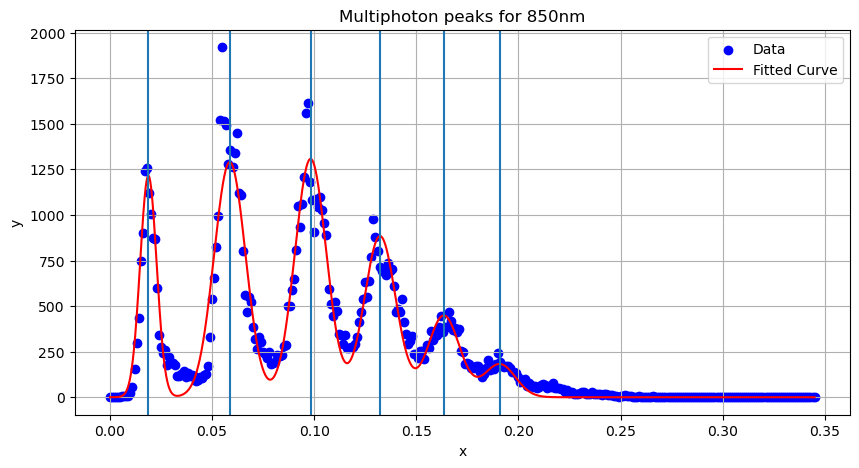

A: 93.29735025104435
mu: 2.027867311106358
x0: 0.018785268434410734
x1: 0.058665604049874996
x2: 0.09821722774756436
x3: 0.13223893599826528
x4: 0.16343466450332322
x5: 0.1908231012448824
s0: 0.004031131183844178
s: 0.007702704606969272


In [13]:
# Define your new function for more Gaussian distributed peaks
def fgauss_850(x, A, mu, x0, x1, x2, x3, x4, x5, s0, s):
    return A * np.exp(-mu) / np.sqrt(2 * np.pi) * (
                                         np.exp(-(x - x0) ** 2 / (2 * s0 ** 2))/ s0+
        mu *                             np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / np.math.factorial(2) * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / np.math.factorial(3) * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s +
        mu ** 4 / np.math.factorial(4) * np.exp(-(x - x4) ** 2 / (2 * s ** 2)) / s +
        mu ** 5 / np.math.factorial(5) * np.exp(-(x - x5) ** 2 / (2 * s ** 2)) / s
        )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_850 = (250, 3, 0.018, 0.058, 0.095, 0.13, 0.16, 0.18, 0.005, 0.007)

# Fit the curve to your data
params_850, covariance_850 = curve_fit(fgauss_850, x_850, y_850, p0=initial_guesses_850, maxfev=20000)

# The optimized parameters are in 'params'
A_fit_850, mu_fit_850, x0_fit_850, x1_fit_850, x2_fit_850, x3_fit_850, x4_fit_850, x5_fit_850, s0_fit_850, s_fit_850 = params_850

# Generate data points for the fitted curve
x_curve_850 = np.linspace(np.min(x_850), max(x_850), 10000)
y_curve_850 = fgauss_850(x_curve_850, *params_850)
# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_850, y_850, label='Data', color='b')
plt.plot(x_curve_850, y_curve_850, label='Fitted Curve', color='r')
plt.axvline(x0_fit_850)
plt.axvline(x1_fit_850)
plt.axvline(x2_fit_850)
plt.axvline(x3_fit_850)
plt.axvline(x4_fit_850)
plt.axvline(x5_fit_850)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Multiphoton peaks for 850nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_850}")
print(f"mu: {mu_fit_850}")
print(f"x0: {x0_fit_850}")
print(f"x1: {x1_fit_850}")
print(f"x2: {x2_fit_850}")
print(f"x3: {x3_fit_850}")
print(f"x4: {x4_fit_850}")
print(f"x5: {x5_fit_850}")
print(f"s0: {s0_fit_850}")
print(f"s: {s_fit_850}")

# Analyse the data from the oscilloscope (406nm)

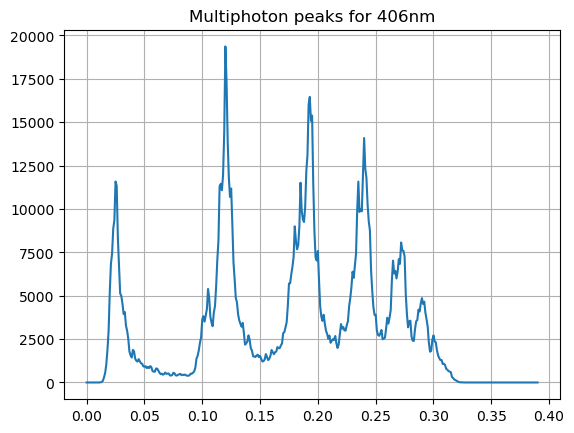

In [14]:
# Read the TXT file into a pandas DataFrame, specifying the delimiter and skipping the first 5 rows.
df_406 = pd.read_csv(data_nofilter_406, delimiter=',', skiprows=5)
data = np.array(df_406)

data = np.array(df_406[df_406.iloc[:, 0]>0])

x_406=data[:, 0]
y_406=data[:, 1]

plt.plot(x_406,y_406)
plt.grid(True)
plt.title('Multiphoton peaks for 406nm')
plt.show()

/home/Artem/.conda/envs/isaac/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


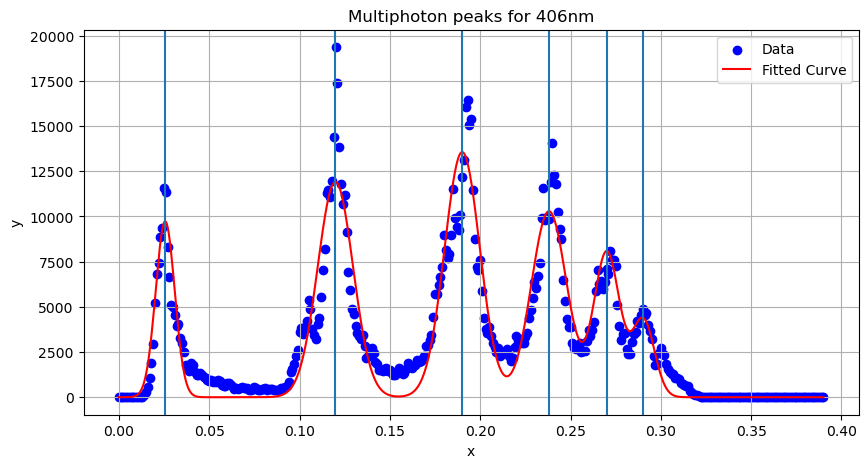

A: 1250.0
mu: 2.276835787846192
x0: 0.02562822871015274
x1: 0.11984499815594894
x2: 0.19004620688159907
x3: 0.23808190973877771
x4: 0.27008709308454654
x5: 0.29032
s0: 0.005258417035053297
s: 0.009778059436519323
s1: 0.007140295360217592
s2: 0.006140156909818271


In [15]:
# Define your function
def fgauss_406(x, A, mu, x0, x1, x2, x3, x4, x5, s0, s, s1, s2):
    return 1250* np.exp(-mu) / np.sqrt(2 * np.pi) * (
                                         np.exp(-(x - x0) ** 2 / (2 * s0 ** 2))/ s0+
        mu *                             np.exp(-(x - x1) ** 2 / (2 * s ** 2)) / s +
        mu ** 2 / np.math.factorial(2) * np.exp(-(x - x2) ** 2 / (2 * s ** 2)) / s +
        mu ** 3 / np.math.factorial(3) * np.exp(-(x - x3) ** 2 / (2 * s ** 2)) / s +
        mu ** 4 / np.math.factorial(4) * np.exp(-(x - x4) ** 2 / (2 * s1 ** 2)) / s1 +
        mu ** 5 / np.math.factorial(5) * np.exp(-(x - 0.29032) ** 2 / (2 * s2 ** 2)) / s2
        )

# Initial guesses for parameters (A, mu, x0, x1, x2, x3, s0, s)
initial_guesses_406 = (1250, 2.5, 0.023, 0.125, 0.185, 0.24, 0.26, 0.29032, 0.004, 0.005, 0.003, 0.002)


# Fit the curve to your data
params_406, covariance_406 = curve_fit(fgauss_406, x_406, y_406, p0=initial_guesses_406, maxfev=200000)

# The optimized parameters are in 'params'
A_fit_406, mu_fit_406, x0_fit_406, x1_fit_406, x2_fit_406, x3_fit_406, x4_fit_406, x5_fit_406, s0_fit_406, s_fit_406, s1_fit_406, s2_fit_406 = params_406

# Generate data points for the fitted curve
x_curve_406 = np.linspace(np.min(x_406), max(x_406), 10000)
y_curve_406 = fgauss_406(x_curve_406, *params_406)
# x5_fit_406 = 0.292
# Create a plot
plt.figure(figsize=(10, 5))
plt.scatter(x_406, y_406, label='Data', color='b')
plt.plot(x_curve_406, y_curve_406, label='Fitted Curve', color='r')
plt.axvline(x0_fit_406)
plt.axvline(x1_fit_406)
plt.axvline(x2_fit_406)
plt.axvline(x3_fit_406)
plt.axvline(x4_fit_406)
plt.axvline(x5_fit_406)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.title('Multiphoton peaks for 406nm')

# Show the plot
plt.show()

# Print the optimized parameters
print(f"A: {A_fit_406}")
print(f"mu: {mu_fit_406}")
print(f"x0: {x0_fit_406}")
print(f"x1: {x1_fit_406}")
print(f"x2: {x2_fit_406}")
print(f"x3: {x3_fit_406}")
print(f"x4: {x4_fit_406}")
print(f"x5: {x5_fit_406}")
print(f"s0: {s0_fit_406}")
print(f"s: {s_fit_406}")
print(f"s1: {s1_fit_406}")
print(f"s2: {s2_fit_406}")

# Make a plot for calibration

A = 0.0320741471*E + 0.0090608344


<Figure size 640x480 with 0 Axes>

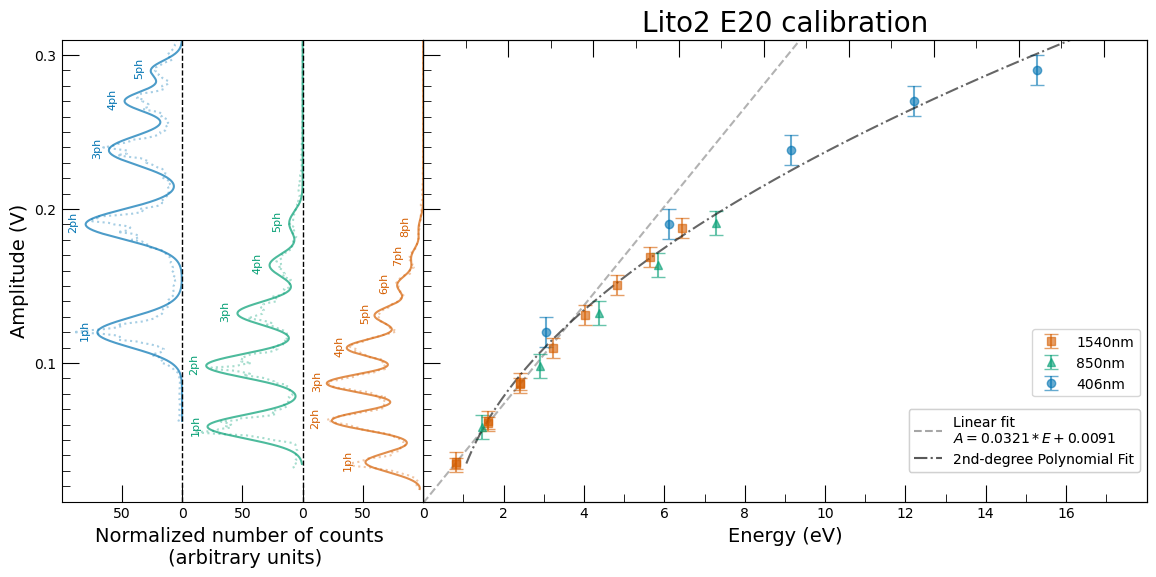

In [ ]:
# # Configure Matplotlib to use LaTeX for text rendering
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif')  # Choose a serif font for the labels

# Create a colorblind-friendly palette from Seaborn
palette = sns.color_palette("colorblind")

# Define a function to convert photon energy to eV
def energy(E):
    energy = Planck*c/(E*10**(-9)*elementary_charge)
    return energy

# Create an array of corresponding energy for each peak
energy_1540 = []
for i in range(1, len(params) - 4):
    energy_1540.append(np.array(energy(1540)*i))

energy_850 = []
for i in range(1, len(params_850) - 4):
    energy_850.append(np.array(energy(850)*i))

energy_406 = []
for i in range(1, len(params_406) - 6):
    energy_406.append(np.array(energy(406)*i))

energy_1540_24db = []
for i in range(1, len(params_1540_24db) - 4):
    energy_1540_24db.append(np.array(energy(1540)*i))

# Specify arbitrary points on the graph for the regression line
x = np.linspace(0, energy_406[-1], 10)

# Add photon peak values to an array
new_cal = np.array(params[3:-2])
old_cal_1540 = np.array(params_1540[3:-2])
old_cal_850 = np.array(params_850[3:-2])
old_cal_406 = np.array(params_406[3:-4])
old_cal_1540_24db = np.array(params_1540_24db[3:-2])

plt.figure()
# fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12, 6),sharey=True)
# Create a figure with subplots having different widths
fig = plt.figure(figsize=(14, 6))
gs = GridSpec(1, 2, width_ratios=[2, 4])  # Adjust the width ratios as needed

# First subplot
ax1 = plt.subplot(gs[1])
ax1.errorbar(energy_1540, old_cal_1540, color=palette[3], alpha = 0.6, yerr=s_fit_old, fmt='s', markersize=6, capsize=5)
b1, b0 = np.polyfit(energy_1540,old_cal_1540, deg=1)
equation_old = f'A = {b1:.4f}*E + {b0:.4f}'
print(f'A = {b1:.10f}*E + {b0:.10f}')
linear, = ax1.plot(x, b0 + b1 * x, color="k", linestyle='--', alpha=0.3, lw=1.5, label = f'Linear fit\n${equation_old}$');

points850 = ax1.errorbar(energy_850, old_cal_850,color=palette[2], label= "850nm", alpha = 0.6, yerr=s_fit_850, fmt='^', markersize=6, capsize=5)
points406 = ax1.errorbar(energy_406, old_cal_406,color=palette[0], label = "406nm", alpha = 0.6, yerr=s_fit_406, fmt='o', markersize=6, capsize=5)
points1540 = ax1.errorbar(energy_1540_24db, old_cal_1540_24db, color=palette[3], label = "1540nm", alpha=0.6, yerr=s_fit_1540_24db, fmt='s', markersize=6, capsize=5)

# # Plot each amplitude to its corresponding energy with s parameter as its uncertainty
# plt.errorbar(energy_1540, new_cal, color="r",yerr=s_fit, fmt='o', markersize=5, capsize=5)
# # Fit linear regression through first 3 points
# a1, a0 = np.polyfit(energy_1540, new_cal, deg=1)
# equation_new = f'y = {a1:.8f}x + {a0:.8f}'
# ax.plot(x, a0 + a1 * x, color="r", linestyle='-', alpha=0.5, lw=1.5, label = f'With filtering\n$y = {a1:.8f}x + {a0:.8f}$');

# plt.errorbar(energy_1540, old_cal_1540, color=palette[3], alpha = 0.6, yerr=s_fit_old, fmt='s', markersize=8, capsize=5)
# b1, b0 = np.polyfit(energy_1540,old_cal_1540, deg=1)
# equation_old = f'y = {b1:.8f}x + {b0:.8f}'
# print(equation_old)
# linear, = ax2.plot(x, b0 + b1 * x, color="k", linestyle='--', alpha=0.3, lw=1.5, label = f'Linear fit');

energies = np.array(energy_1540 + energy_850 + energy_406 +energy_1540_24db)
amplitudes = np.concatenate([old_cal_1540, old_cal_850, old_cal_406, old_cal_1540_24db])
y_E = np.linspace(np.min(amplitudes), np.max(amplitudes)+0.1, 1000)
cffs = np.polyfit(amplitudes, energies, deg=2)
polynomial = np.poly1d(cffs)
x_E = polynomial(y_E)

poly, = plt.plot(x_E, y_E, alpha = 0.6, linestyle = '-.', label=f'2nd-degree Polynomial Fit'  , color='k')
# ax.plot(x_E, c0 + c1*x_E + c2*x_E^2 + c3*x_E^3 + c4*x_E^4, color="k", linestyle='--', alpha=0.5, lw=1.5, label='No filtering');

# Set custom major and minor ticks for x and y axes
major_xticks = np.arange(0, 18, 2)
minor_xticks = np.arange(0, 18, 1)
major_yticks = [0.1, 0.2, 0.3]
minor_yticks = np.arange(0.01, 0.3, 0.01)

ax1.set_xticks(major_xticks, minor=False)
ax1.set_xticks(minor_xticks, minor=True)
ax1.set_yticks(major_yticks, minor=False)
ax1.set_yticks(minor_yticks, minor=True)

# Create right, top, and bottom axes
ax3 = ax1.twiny()  # Create a top axis

# Set custom major and minor ticks for the new axes
ax3.set_xticks(major_xticks, minor=False)
ax3.set_xticks(minor_xticks, minor=True)

ax3.set_xticklabels([])

# Increase tick size (length)
for ax in [ax1, ax3]:
    ax.tick_params(axis='both', which='major', labelsize=10, length=12, direction='in')
    ax.tick_params(axis='both', which='minor', length=6, direction='in')

# # Set major and minor ticks for the y-axis
# ax1.set_yticks([0.1, 0.2, 0.3], minor=False)
# ax1.set_yticks(np.arange(0.01, 0.3, 0.01), minor=True)
# # Set major and minor ticks for the x-axis
# ax1.set_xticks(np.arange(0, 18, 2), minor=False)
# ax1.set_xticks(np.arange(0, 18, 1), minor=True)

# # Increase tick size (length)
# ax1.tick_params(axis='both', which='major', labelsize=10, length=12, direction='in')  # Major tick length
# ax1.tick_params(axis='both', which='minor', length=6, direction='in') 

plt.ylim(0.02, 0.31)
ax1.set_xlim(0,18)

primary_legend = plt.legend(handles=[points1540, points850, points406], loc='center right', bbox_to_anchor=(1, 0.3))
plt.gca().add_artist(primary_legend)
secondary_legend = plt.legend(handles=[linear, poly],loc='lower right', bbox_to_anchor=(1, 0.05))
plt.gca().add_artist(secondary_legend)

# Create the secondary histogram-like plot
ax2 = plt.subplot(gs[0], sharey=ax1) #ax.twiny()  # Share y-axis with ax1 and create a new x-axis
ax2.plot(y_1540_24db[20:]/np.max(y_1540_24db[20:])*80,x_1540_24db[20:], alpha = 0.35, linestyle=':', markersize = 3, color = palette[3])
ax2.plot(y_curve_1540_24db[550:]/np.max(y_curve_1540_24db[550:])*80, x_curve_1540_24db[550:], alpha = 0.7, color=palette[3])

ax2.plot(y_850[32:]/np.max(y_850[32:])*90+100,x_850[32:], alpha = 0.35, linestyle=':', markersize = 3, color = palette[2])
ax2.plot(y_curve_850[1000:]/np.max(y_curve_850[1000:])*80+100, x_curve_850[1000:], alpha = 0.7, color=palette[2])

ax2.plot(y_406[62:]/np.max(y_406[62:])*90+200,x_406[62:], alpha = 0.35, linestyle=':', markersize = 3, color = palette[0])
ax2.plot(y_curve_406[1600:]/np.max(y_curve_406[1600:])*80+200, x_curve_406[1600:], alpha = 0.7, color=palette[0])

# Add vertical lines
ax2.axvline(x=100, color='k', linestyle='--', linewidth = 1)
ax2.axvline(x=200, color='k', linestyle='--',  linewidth = 1)

# Set major and minor ticks for the y-axis
ax2.set_yticks([0.1, 0.2, 0.3], minor=False)
ax2.set_yticks(np.arange(0.01, 0.3, 0.01), minor=True)

# Increase tick size (length)
ax2.tick_params(axis='both', which='major', labelsize=10, length=12, direction='in')  # Major tick length
ax2.tick_params(axis='both', which='minor', length=6, direction='in') 

ax2.set_xticks(np.arange(0,300,50))
ax2.set_xticklabels([None,50,0,50,0,50])
ax2.invert_xaxis()
ax2.set_xlim(300,0)

plt.grid(False)

for k, i in enumerate(params_1540_24db[3:-2], start=1):
    j = np.where(x_1540_24db >= i)[0][0]
    ax2.text(y_1540_24db[j] / np.max(y_1540_24db) * 80 +10, i-0.004, f'{k}ph', fontsize=8, color=palette[3], rotation=90, ha='center')

for k, i in enumerate(params_850[3:-2], start=1):
    j = np.where(x_curve_850 >= i)[0][0]
    ax2.text(y_curve_850[j]/np.max(y_curve_850)*80+110, i-0.004, f'{k}ph', fontsize=8, color=palette[2], rotation=90, ha='center')

for k, i in enumerate(params_406[3:-4], start=1):
    j = np.where(x_curve_406 >= i)[0][0]
    ax2.text(y_curve_406[j]/np.max(y_curve_406)*80+210, i-0.004, f'{k}ph', fontsize=8, color=palette[0], rotation=90, ha='center')

# # Define the coordinates and size of the subplot within the main plot
# left, bottom, width, height = 0.14, 0.65, 0.278, 0.2
# ax_inside = plt.axes([left, bottom, width, height])
# ax2 = ax_inside.twinx()
# # Plot the data in the subplot
# ax_inside.plot(x_1540_24db, y_1540_24db, label='Multiphoton peaks for 1540nm', color='red')
# ax_inside.grid(True)

# # Turn off the y-axis label in the subplot
# ax_inside.set_yticks([])
# ax2.set_yticks([])
# ax_inside.set_xticks(params_1540_24db[3:-2])
# ax2.set_xticks(params_1540_24db[3:-2])
# ax_inside.set_xticklabels(np.round(x, 2) for x in energy_1540_24db)

# # ax2.set_xticklabels(range(1,8))
# # ax2.xaxis.set_ticks_position("top")
# ax_inside.set_xlim(0.023, 0.18)
# ax_inside.set_xlabel('Energy (eV)')

# plt.text(1.1, 0.0898, equation_new, fontsize=12, color='r')
# plt.text(1.1, 0.0865, equation_old, fontsize=12, color='b')

ax1.set_xlabel('Energy (eV)', fontsize=14)
ax2.set_xlabel('Normalized number of counts \n (arbitrary units)', fontsize=14)
ax2.set_ylabel('Amplitude (V)', fontsize=14)
# ax1.set_title('Lito2 E20 calibration', fontsize=20)
plt.subplots_adjust(wspace=0)
# Adjust layout
# plt.tight_layout()

plt.show()

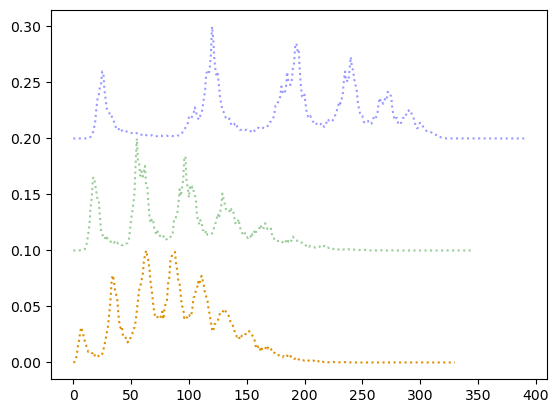

In [17]:
multiphoton, = plt.plot(1000*x_1540_24db, y_1540_24db/np.max(y_1540_24db)*0.1 , label = '1540nm Multiphoton distribution', alpha = 1,  linestyle=':', markersize = 3, color = palette[1])
plt.plot(x_850*1000, 0.1+y_850/np.max(y_850)*0.1, alpha = 0.4, linestyle=':', markersize = 3, color = "green")
plt.plot(1000*x_406, 0.2+y_406/np.max(y_406)*0.1, alpha = 0.4,  linestyle=':', markersize = 3, color = "blue")